# Analysis of large set of Src simulations on Folding@home (project 10467), one starting configuration

####May 1, 2015

####This is some initial MSM building Src simulations.

##Section 0: Longest Sim

In [1]:
#Import libraries

import matplotlib.pyplot as plt
import mdtraj as md
import glob
import numpy as np
from msmbuilder.dataset import dataset
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Import longest trajectory.

t = md.load("run0-clone138.h5")

The timestep for these simulations is 2 fs (can be found in /data/choderalab/fah/initial-models/projects/ABL1_HUMAN_D0_V1/RUN0/integrator.xml [stepSize=".002"]).

Assuming the write frequency is every 125000 steps (can't find project.xml, assuming same as for MEK etc. projects). This means that each frame is 250 ps.


In [3]:
frame = np.arange(len(t))[:, np.newaxis]

# Using 0.25 so that units are in ns.
time = frame * .250

sim_time = time[-1] * 1e-3

print "Length of this longest simulation of Src is %s us." % ''.join(map(str, sim_time)) 

Length of this longest simulation of Src is 1.98975 us.


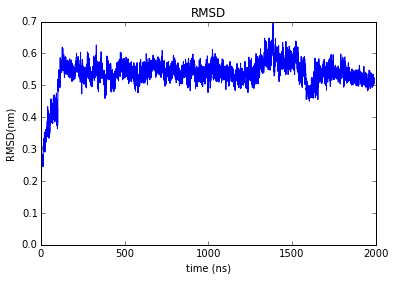

In [4]:
rmsd = md.rmsd(t,t,frame=0)
plt.plot(time, rmsd)
plt.xlabel('time (ns)')
plt.ylabel('RMSD(nm)')
plt.title('RMSD')

#####Load all trajectories > 1 us.
How many frames is 1us?  1000/.25 = 4000 frames!

In [5]:
# For now making dir long_sims in bash using:
# > for file in $(find * -type f -size +300000); do cp $file long_sims/$file; done

filenames = glob.glob("run0*.h5")
trajectories = [md.load(filename) for filename in filenames]
len(trajectories)

263

There are __ sims in this. The shortest one is run0-clone93.h5.

In [6]:
t_long_min = md.load("run0-clone93.h5")

frame = np.arange(len(t_long_min))[:, np.newaxis]

# Using 0.25 so that units are in ns.
time = frame * .250

sim_time = time[-1] * 1e-3

print "Length of run0-clone1.h5 %s us." % ''.join(map(str, sim_time)) 

Length of run0-clone1.h5 1.03975 us.


In [7]:
frame = np.arange(len(trajectories))[:, np.newaxis]

# Using 0.25 so that units are in ns.
time = frame * .250

sim_time = time[-1] * 1e-3

print "The total length of all these long sims is %s us." % ''.join(map(str, sim_time)) 

The total length of all these long sims is 0.0655 us.


## Section 1: Building an MSM.

In [8]:
from msmbuilder import msm, featurizer, utils, decomposition

In [9]:
# Make dihedral_features
dihedrals = featurizer.DihedralFeaturizer(types=["phi", "psi", "chi2"]).transform(trajectories) 

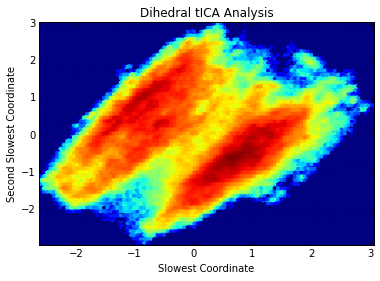

In [10]:
# Make tICA features 
tica = decomposition.tICA(n_components = 4)
X = tica.fit_transform(dihedrals)
#Note the default lagtime here is 1 (=250ps), 
#which is super short according to lit for building reasonable protein MSM.

Xf = np.concatenate(X)
hexbin(Xf[:,0], Xf[:, 1], bins='log')
title("Dihedral tICA Analysis")
xlabel("Slowest Coordinate")
ylabel("Second Slowest Coordinate")

savefig("src_10467_msm.png", bbox_inches="tight")

## Section 2: Comparing MSM to Danny's ensembler outputs.

In [11]:
#Load trajectory with ensembler models
t_models = md.load("../../ensembler-models/traj-refine_implicit_md.xtc", top = "../../ensembler-models/topol-renumbered-implicit.pdb")

In [12]:
#Now make dihedrals of this.
dihedrals_models = featurizer.DihedralFeaturizer(types=["phi", "psi", "chi2"]).transform([t_models])
x_models = tica.transform(dihedrals_models)
#do not use fit here because don't want to change tica object, want to use one generated from sims.

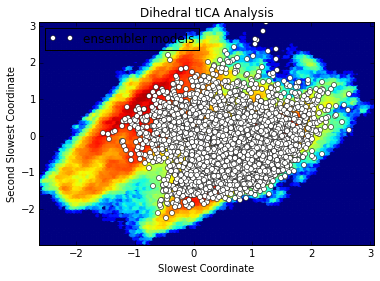

In [13]:
#Now plot on the slow MSM features found above.
hexbin(Xf[:,0], Xf[:, 1], bins='log')
plot(x_models[0][:, 0], x_models[0][:, 1], 'o', markersize=5, label="ensembler models", color='white')
title("Dihedral tICA Analysis")
xlabel("Slowest Coordinate")
ylabel("Second Slowest Coordinate")
legend(loc=0)

savefig("src_10467_msm_wmodels.png", bbox_inches="tight")